# Data viz for bird brains


![](https://i.kym-cdn.com/photos/images/original/000/844/924/126.jpg)

## Introduction

Today, we'll be focusing on some of the neat ways to display you data using a few different graphing packages that go beyond our usual suspect, `matplotlib`. 

Data viz is about a lot more than just displaying your data - by visualizing your data, you may **discover relationships or patterns** that stats alone might not have clued you into. Thus, data viz shouldn't be thought of solely as a last step in data analysis, but rather an iterative and explorative part of your data processing.

The dataset we'll be playing with today is from a study published in 2016 by Olcowicz et al. titled 
[Birds have primate-like numbers of neurons in the forebrain](http://www.pnas.org/content/early/2016/06/07/1517131113). The dataset is straight-forward as it is mostly brain cell counts of various brain areas from various bird species. 

The major finding of this paper (i.e. the title) provides neurobiological support for a major shift in our idea of what it means to be a "bird brain." Mounting evidence from this and other studies (and YouTube videos, see links) demonstrate the emotional and cognitive intelligence of our distant but warm-blooded relatives. For example, [crows](https://www.youtube.com/watch?v=cbSu2PXOTOc) make and use tools, [magpies](https://www.youtube.com/watch?v=60Zg9sGnQf8) gather to mourn another's death, and [keas](https://www.youtube.com/watch?v=6bbWF6Gx8UM) produce a laughter-like vocalization when engaging in play that seems to be contagious. But how can a brain as small as a songbird's engage in complex problem solving and rich social regulation? Based on the results of this study, part of what explains advanced avian cognition is that bird brains pack a high density of brain cells.

Here are some comparisons between bird and mammal brains. The two numbers under each brain are the brain mass in grams and the total number of brain neurons in millions.


<img src="braincmp.jpg">

This is all super neat, and Alex and I would be happy to nerd out out birds all day. But our goal today isn't to convince you that birds are fascinating and empathetic and far from feathered robots. **Our goal today is to learn how to craft some graphs that are clear, polished, and information-dense.** So let's hop to it, shall we?

As always, we begin by loading the libraries we'll need.

In [1]:
# Import libraries
import os
import glob as glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource, HoverTool, LinearColorMapper
from bokeh.palettes import inferno, plasma
from bokeh.plotting import figure, show
from bokeh.transform import transform

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.metrics import classification_report 

pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.2f}'.format  # limit the number of digits displayed after the decimal to 2

## Loading the data
It's not uncommon for data to be spread out over multiple files. In our case, the data lives in 6 different .csv files, each named after the brain region that they were collected from. Sure, we could write a line of code for each file we need to import, ending up with 6 lines of code and 6 dataframes. But what if our data were split into dozens or even hundreds of files? (think imaging files). Instead of writing a line of code for each data file, let's utilize our programmatic powers to do this more efficiently and flexibly in such a way that it can be applied to any number of data files.
### Exercise
Before we can use a `read` function, we first need to generate a list of data files we want to import. Finding this method from the `glob` package is not exactly intuitive, so we've gone ahead and written the code for you. 

Go ahead and run it, then display it. Based on the output, what do you think this line of code is doing? What type of object is `data_files`?

In [2]:
data_files = glob.glob("*bb.csv")

# Answer
display(data_files)
type(data_files)

['wholebrain_bb.csv',
 'diencephalon_bb.csv',
 'cerebellum_bb.csv',
 'telencephalon_bb.csv',
 'brainstem_bb.csv',
 'tectum_bb.csv']

list

`glob` is a python module that searches for filenames containing a specified string or pattern within your current working directory. Here, we told `glob` to search within the current working directory for any files that end in `bb` + our data file format, `.csv`. 

Note: The `*` is a special "wildcard" character indicating that any string of characters can precede the `bb.csv`.

Now that we have our list of data files, we need to import them. For the sake of time, we've provided some code to do this below. Have a look-see. What is each line doing?

**Bonus question 1**: Why do we define the object `data` _first_ & _outside_ the for loop?

**Bonus question 2**: How could you re-write this for loop to a single line of code using list comprehension?

In [3]:
data = []
for file in data_files:
    df = pd.read_csv(file, index_col=None, header=0)
    data.append(df)

Instead of writing one line of code per data file, we've made use of a for loop. As it loops through each .csv file in our `data_files` list, it:

   * reads the data into a pandas dataframe called `df` (think of this a temporary holding variable)
    
   * appends (adds) that dataframe to a list called `data`

**Bonus answer 1**: We need to define data outside the for loop to avoid getting a python error that says
`NameError: name 'data' is not defined'`. Basically, you can't run a method (`.append` in our case) on an object that didn't exist _before_ calling the method.

Note that initializing/preallocating an empty data structure to fill as you process/analyze is very common practice, as it is usually less computationally expensive than iteratively restructuring, e.g. adding a row to an array with each iteration of a loop.

**Bonus answer 2**: The above four lines can be reduced to one using a list comprehension:

    data = [pd.read_csv(file, index_col=None, header=0) for file in data_files]

    

### Exercise

If you haven't already, take a look at this `data` object. What type of object is it?

In [4]:
# Answer
type(data)

list

What does this object contain? Do you see any problems with how this is formatted if, say, we wanted to plot values from different brain regions on the same graph?

In [5]:
# Answer
display(data)

[     id common_name  mass       cells     neurons  non-neurons brain_region
 0   CF1        Rook  8.06  2430200000  1549231524    880968476  whole brain
 1   CF2        Rook  8.68  2405490000  1473216160    932273840  whole brain
 2   CF3        Rook  8.33  2257131429  1503713918    753417510  whole brain
 3   CM1     Jackdaw  5.83  1448356667   898829577    549527090  whole brain
 4   CM2     Jackdaw  5.86  1453310000   914302312    539007688  whole brain
 ..  ...         ...   ...         ...         ...          ...          ...
 68  TA1    Barn Owl  5.15  1142920417   649397097    493523320  whole brain
 69  TA2    Barn Owl  5.89  1224295000   690585275    533709725  whole brain
 70  TA3    Barn Owl  5.81  1268876250   728649511    540226739  whole brain
 71  DN1         Emu 20.37  2759416667  1314881847   1444534820  whole brain
 72  DN2         Emu 23.25  2968691667  1355913675   1612777992  whole brain
 
 [73 rows x 7 columns],
      id common_name  mass      cells   neurons  n

Well, the good news is that we've got the data from our 6 .csv files imported, and we could've just as easily handled importing 200 (or any other arbitrary number of) files with our glob + for loop sleight of hand. 

These data sets contain the following columns:
* **id**, an alphanumeric tag indicating which individual animal the data is from
* **common_name**, the common name for the species
* **mass**, the mass of the brain region specified in grams (g)
* **cells**, the total number of cells in the brain region specified
* **neurons**, the total number of neurons in the brain region specified
* **non-neurons**, the total number of non-neurons in the brain region specified
* **brain_region**, area of the brain from which the data originated

Unfortunately, instead of ending up with all of our data in one dataframe object, we're left with a **list of dataframes** in an object called `data`. This could lead to some clunky code if we want to transform or plot data across data sets. It would be a lot easier to manipulate our data if it were all in one dataframe...

### Exercise

How can we combine or (hint!) **concatenate** a list of dataframes into a single dataframe? Find a pandas method that will take our `data` list and do just this, and name your new dataframe `bb`.

Reminder: `pd.<TAB>` is your friend for finding a suitable method. 

In [6]:
# Answer
bb = pd.concat(data)
bb

,id,common_name,mass,cells,neurons,non-neurons,brain_region
0,CF1,Rook,8.06,2430200000,1549231524,880968476,whole brain
1,CF2,Rook,8.68,2405490000,1473216160,932273840,whole brain
2,CF3,Rook,8.33,2257131429,1503713918,753417510,whole brain
3,CM1,Jackdaw,5.83,1448356667,898829577,549527090,whole brain
4,CM2,Jackdaw,5.86,1453310000,914302312,539007688,whole brain
...,...,...,...,...,...,...,...
68,TA1,Barn Owl,0.19,30875000,7925134,22949866,tectum
69,TA2,Barn Owl,0.19,38066667,9935400,28131267,tectum
70,TA3,Barn Owl,0.20,35218750,10143000,25075750,tectum
71,DN1,Emu,1.08,143200000,31074400,112125600,tectum


Ta-daaa! Every datapoint together at last. Let's do some data manipulation now.

## Data maniupulation
This dataset contains two types of numerical data: mass (g) and cell counts. This is a good place to start, but limits the kinds of comparisons we can do if we'd like to control for, say brain size. For example, if you predict that the number of neurons correlate in a brain correlates with the level of intelligence for that animal, you might predict that an ostrich would be far more intelligent than a crow. But consider the difference in size of an ostrich brain vs. that of a crow...

### Exercise
One way to "normalize" these cell counts is to transform cell counts into cell densities. Before we do that, let's convert the `mass` column from grams to miligrams. Save these converted values as `mass_mg` to `bb`.

Hint: if you're like me and get easily turned around by unit conversion, think about whether the final value should be bigger or smaller than the starting value.

In [7]:
# Answer
bb["mass_mg"] = bb["mass"]*1000
bb

,id,common_name,mass,cells,neurons,non-neurons,brain_region,mass_mg
0,CF1,Rook,8.06,2430200000,1549231524,880968476,whole brain,8060.00
1,CF2,Rook,8.68,2405490000,1473216160,932273840,whole brain,8680.00
2,CF3,Rook,8.33,2257131429,1503713918,753417510,whole brain,8330.00
3,CM1,Jackdaw,5.83,1448356667,898829577,549527090,whole brain,5830.00
4,CM2,Jackdaw,5.86,1453310000,914302312,539007688,whole brain,5860.00
...,...,...,...,...,...,...,...,...
68,TA1,Barn Owl,0.19,30875000,7925134,22949866,tectum,186.00
69,TA2,Barn Owl,0.19,38066667,9935400,28131267,tectum,193.00
70,TA3,Barn Owl,0.20,35218750,10143000,25075750,tectum,197.00
71,DN1,Emu,1.08,143200000,31074400,112125600,tectum,1076.00


Good job! 

### Exercise
Now calculate the density of neurons per mg of brain tissue and assign it to a new column called "neuronal_density" in our `bb` dataframe. What is the unit of this column?


In [8]:
# Answer
bb["neuronal_density"] = bb["neurons"]/bb["mass"]
bb

,id,common_name,mass,cells,neurons,non-neurons,brain_region,mass_mg,neuronal_density
0,CF1,Rook,8.06,2430200000,1549231524,880968476,whole brain,8060.00,192212347.89
1,CF2,Rook,8.68,2405490000,1473216160,932273840,whole brain,8680.00,169725364.06
2,CF3,Rook,8.33,2257131429,1503713918,753417510,whole brain,8330.00,180517877.31
3,CM1,Jackdaw,5.83,1448356667,898829577,549527090,whole brain,5830.00,154173169.30
4,CM2,Jackdaw,5.86,1453310000,914302312,539007688,whole brain,5860.00,156024285.32
...,...,...,...,...,...,...,...,...,...
68,TA1,Barn Owl,0.19,30875000,7925134,22949866,tectum,186.00,42608247.31
69,TA2,Barn Owl,0.19,38066667,9935400,28131267,tectum,193.00,51478756.48
70,TA3,Barn Owl,0.20,35218750,10143000,25075750,tectum,197.00,51487309.64
71,DN1,Emu,1.08,143200000,31074400,112125600,tectum,1076.00,28879553.90


### Exercise
Repeat this operation of calculating cell counts per mg for both the `cells` and `non-neurons` columns, saving the resulting densities to columns named `cellular_density` and `non-neuronal_density`.

In [9]:
# Answer
bb["cellular_density"] = bb["cells"]/bb["mass_mg"]
bb["non-neuronal_density"] = bb["non-neurons"]/bb["mass_mg"]
bb

,id,common_name,mass,cells,neurons,non-neurons,brain_region,mass_mg,neuronal_density,cellular_density,non-neuronal_density
0,CF1,Rook,8.06,2430200000,1549231524,880968476,whole brain,8060.00,192212347.89,301513.65,109301.30
1,CF2,Rook,8.68,2405490000,1473216160,932273840,whole brain,8680.00,169725364.06,277130.18,107404.82
2,CF3,Rook,8.33,2257131429,1503713918,753417510,whole brain,8330.00,180517877.31,270964.16,90446.28
3,CM1,Jackdaw,5.83,1448356667,898829577,549527090,whole brain,5830.00,154173169.30,248431.68,94258.51
4,CM2,Jackdaw,5.86,1453310000,914302312,539007688,whole brain,5860.00,156024285.32,248005.12,91980.83
...,...,...,...,...,...,...,...,...,...,...,...
68,TA1,Barn Owl,0.19,30875000,7925134,22949866,tectum,186.00,42608247.31,165994.62,123386.38
69,TA2,Barn Owl,0.19,38066667,9935400,28131267,tectum,193.00,51478756.48,197236.62,145757.86
70,TA3,Barn Owl,0.20,35218750,10143000,25075750,tectum,197.00,51487309.64,178775.38,127288.07
71,DN1,Emu,1.08,143200000,31074400,112125600,tectum,1076.00,28879553.90,133085.50,104205.95


Right-o! Densities abound. Let's do one last manipulation before moving onto graphing.

### Exercise
Note that there are 3 individuals (encoded as 3 unique `id`s) for each species in this dataset, each with data for 6 different brain regions. Calculate the **averages** for our numerical data by **both species and brain region** so that each species has one row of data per brain region. Call this new dataframe `bb_means`.

Hint: You'll need to create a **grouping variable**, and pass that grouping function an additonal parameter: `as_index=False`.

In [10]:
# Answer
grouping_var = bb.groupby(["common_name","brain_region"], as_index=False)
bb_means = grouping_var.mean()
bb_means

,common_name,brain_region,mass,cells,neurons,non-neurons,mass_mg,neuronal_density,cellular_density,non-neuronal_density
0,Alexandrine Parakeet,brainstem,0.27,47535000.00,2838283.67,44696716.33,271.33,10533470.20,175321.63,164788.16
1,Alexandrine Parakeet,cerebellum,0.51,440383333.33,361355816.67,79027516.67,505.67,718953199.00,875826.94,156873.74
2,Alexandrine Parakeet,diencephalon,0.29,53070000.00,5157080.33,47912919.67,292.33,17617527.28,181499.50,163881.98
3,Alexandrine Parakeet,tectum,0.24,70326666.67,22945853.33,47380813.33,239.67,96237023.36,294560.95,198323.92
4,Alexandrine Parakeet,telencephalon,4.39,1057683333.33,703960515.00,353722818.33,4390.00,160875762.15,241515.32,80639.55
...,...,...,...,...,...,...,...,...,...,...
163,Zebra Finch,cerebellum,0.06,67401666.67,56609690.67,10791976.00,56.00,1009159799.88,1201173.21,192013.41
164,Zebra Finch,diencephalon,0.03,7842777.67,2395688.67,5447089.33,31.67,76071287.82,248496.07,172424.80
165,Zebra Finch,tectum,0.04,17746666.67,10618316.33,7128350.33,42.67,249447963.48,416344.80,166896.84
166,Zebra Finch,telencephalon,0.33,93556666.67,64663021.00,28893645.67,327.33,198672672.51,287213.18,88540.50


A little help from `.groupby` and birb's your uncle! 

Jumping ahead a teeny bit, we include the `as_index=False` parameter is so that `seaborn` treats the `common_name` and `brain_region` columns as categorical **variables** instead of **indices**.  

## Data visualization using matplotlib
You've seen it at work before - good ol' matplotlib. Let's do a quick refresher.

### Exercise
Do you remember how to make a scatterplot using `matplotlib`? Create a scatterplot using `matplotlib` (imported as `plt`) with mass on the x axis and neurons on the y axis. Source this data from `bb`.

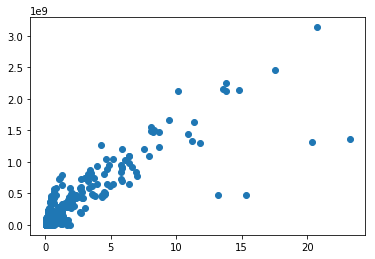

In [11]:
plt.scatter(x="mass", y="neurons", data=bb)

Woah! There are some serious outliers here. Sure would be nice to know what those are *without* consulting the dataframe itself... but more on that later!

What if we wanted to add another dimension to this plot, such as neuronal density? How might we add to our scatterplot to include density?

...

Any ideas?

...

One possible solution is to encode the density as the color of the markers (similar to a heatmap.) Another solution is to change the size of the markers to encode density. Can we scale our marker size to encode neuronal density by passing an additional argument to `plt.scatter`?

### Exercise
Use the '?' to inspect the documentation for plt.scatter. Do you see any parameters that set the **marker size**?

In [12]:
# Answer
plt.scatter?

According to a quick glance at the documentation, the 's' parameter appears to deal with marker size. What happens when we pass 's' our neuronal density column? Try it here.

Hint: The resulting graph may not look... informative.

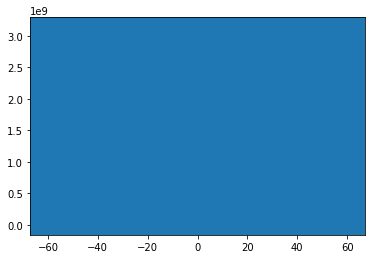

In [13]:
# Answer
plt.scatter(x="mass", y="neurons", s="neuronal_density", data=bb_means)

Wow, a giant blue box, enlightening, eh? Looks like we're going to have to do some more fanangling and transforming to get `matplotlib` to encode our density data as marker size. Everyone, please turn to page 1 of the User Guide for `matplotlib` and begin reading up on-

JUST KIDDING! Ain't nobody got time for that. Not when there are perfectly good graphing packages to be tapped!

## Data visualization using seaborn

Lucky for us, there's a better way to add additional dimensions to your plots using a python graphing package we have brushed upon before by the name of `seaborn`.`seaborn`'s parameters look a lot like `matplotlib`, but include parameters that make **semantic groupings** (e.g. marker color as an indicator of brain area) a breeze.

Let's start with a bare bones `seaborn` scatterplot. 

### Exercise
Using `seaborn` (imported as `sns`), create a scatterplot with mass on the x axis and neuron count on the y axis sourcing data from our `bb_means` dataframe.

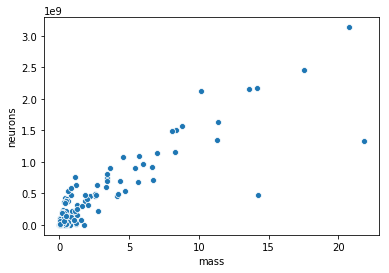

In [15]:
# Answer
sns.scatterplot(x="mass", y="neurons", data=bb_means)

### Exercise
Now take a second to generate the same plot neurons vs mass from `bb_means`using matplotlib. Do you see any differences between this graph and that generated with `matplotlib`?

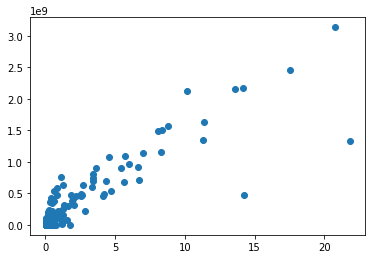

In [16]:
# Answer
plt.scatter(x="mass", y="neurons", data=bb_means)

There are a two differences that pop out at me:
* marker outlines
* axis labels

Already, `seaborn` is coming out ahead in terms of readability, wouldn't you agree? 

Under the hood, `seaborn` uses `matplotlib`. It just uses more sensible "defaults" for many of the plotting functions (e.g., you can achive marker outlines in matplotlib, but you have to pass in additional arguments, which makes for more work.)

### Exercise

Let's recreate that same neurons vs mass scatter plot using `seaborn`, assign your plot to an object (handle) named `p`, then add two lines of code involving methods on `p` to **scale** the x and y axes to be log-scaled. 

Hint: The methods for x and y scaling are somewhere in the list pulled up by entering `p.set_<TAB>`. Check the method's documentation to determine what **value** you should pass to the function for a log scale.

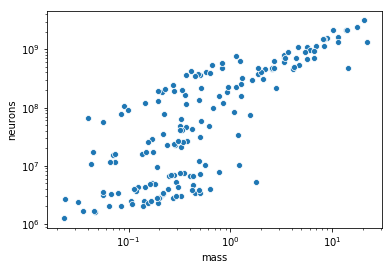

In [17]:
# Answer
p = sns.scatterplot(x="mass", y="neurons", data=bb_means)
p.set_xscale('log')
p.set_yscale('log')

Very nice! Now there is less overlap between points, so we can see more of the data. We'll make these same log-scaling modifications to the next several plots, so keep it handy on your copy-paste clipboard.

### Exercise
Let's see if we can find a way to encode neuronal density in the size of each marker. Inspect the documentation for `sb.scatterplot` to find additional parameters that set the size of markers. Then pass our `neuronal_densities` column to this additional parameter to create a scatterplot with densities indicated by marker size.

Continue to assign your plot to `p` and copy&paste the log-scaling methods from the previous exercise.

Hint: You might find more than one parameter that have to do with marker size. Try running your code with each one separately if you're not sure which one is the right one.

In [18]:
sns.scatterplot?

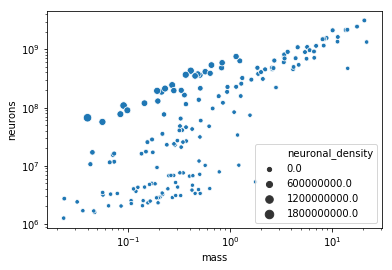

In [19]:
# Answer
p=sns.scatterplot(x="mass", y="neurons", size="neuronal_density", data=bb_means)
p.set_xscale('log')
p.set_yscale('log')

It's a bit hard to see the differences between small dots and large dots here... Surely there must be a way to adjust the ranges of marker sizes.

### Exercise
Let's pass `sb.scatterplot` another parameter, `sizes`, as a tuple, which is a data type formated as two numbers separated by a comma and surrounded by parenthesis, e.g. (12,200). Experiment with different values for `sizes` until you find one that you like. Again, add your log scaling modification.

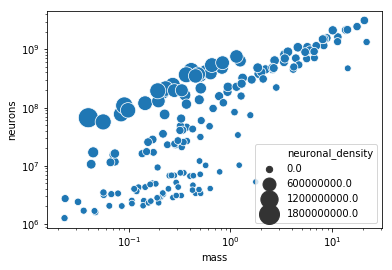

In [20]:
# Answer
p = sns.scatterplot(x="mass", y="neurons", data=bb_means, size="neuronal_density", sizes=(40,400))
p.set_xscale('log')
p.set_yscale('log')

Neat! And look at that auto-generated legend! Our buddy `seaborn` does it again. Let's add one last dimension to this plot before moving on to some interactive graphs.

### Exercise
Based on the plot above, it appears that the larger dots are clustering around the smaller masses. But remember that this dataset contains cell counts (and our added densities) for **multiple brain regions**. 

Take another gander at `sb.scatterplot`'s documentation on parameters to find one that deals with the **color** of the markers. Then, pass it our `brain_region` column to recreate the plot above with brain region encoded as color.

Hint: What's another word for color?

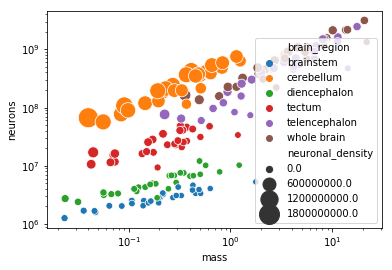

In [21]:
# Answer
p = sns.scatterplot(x="mass", y="neurons", hue="brain_region", size="neuronal_density", sizes=(40, 400), data=bb_means)
p.set_xscale('log')
p.set_yscale('log')

Piece of cake! Now we see that the high density datapoints at lower masses all belong to densities of the cerebellum. This is consistent with what's known about neuronal density in mammals, where ~70% of your neurons are not, as one might expect, in your cerebrum, but rather jam-packed into the granule cell layer of your cerebellum.

### Exercise

One last final tweak - the legend has gotten rather large now that it must describe our two **semantic groupings**: brain region by marker color and neural density by marker size. 

Run the code below to move our legend outside the plotting area.

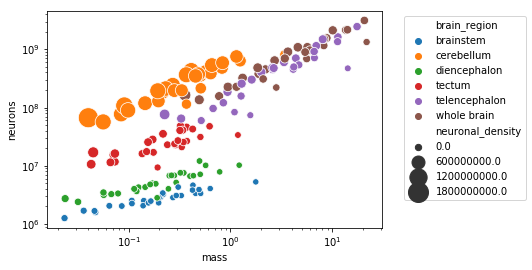

In [22]:
p = sns.scatterplot(x="mass", y="neurons", hue="brain_region", size="neuronal_density", sizes=(40, 400), data=bb_means)
p.set_xscale('log')
p.set_yscale('log')
plt.legend(bbox_to_anchor=(1.05, 1))

A rainbow of data, isn't it beautiful?

Notice that we're using `plt.legend` here to modify the legend, not `sns.legend`. This is because `seaborn` was built on top of `matplotlib`, so it utilizes some of `matplotlib`'s methods.

To briefly break down how this line of code works, you can think of your plotting area as an x-y coordinate system that ranges from 0 to 1 along each axis, where y=1 be the top edge and x=1 would be the right edge of your plot. We set the `bbox_to_anchor` parameter to start drawing the legend at x=1.05, slightly beyond the x=1 edge of our plot, and y=1, in line with the top edge of our plot. If you're confused, try changing the vaules passed to `bbox_to_anchor` and see how it changes the placement of your legend.

## Data visualization with bokeh
Take another look at our neurons vs mass plot. What are the values at higher masses that don't follow the same trend as the other data points? `matplotlib` isn't too informative when it comes to determining what each of the points on the scatter plot represent. For that, we will use an interactive data visualization package for python called `bokeh`. Using `bokeh` we will create a visually appealing, interactive plot which will allow us to learn about individual data points.




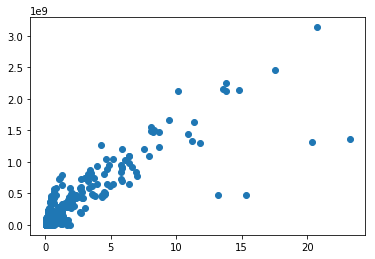

In [31]:
plt.scatter(x="mass", y="neurons", data=bb)

### Exercise

Lets's begin by making variables `x` that corresponds to mass, `y` that corresponds to neurons, `desc` that corresponds to common_name, `ndensity` that corresponds to neuronal_density, and `brain_region` that corresponds to brain_region.

In [32]:
# Answer
x = bb['mass']
y = bb['neurons']
desc = bb['common_name']
ndensity = bb['neuronal_density']
brain_region = bb["brain_region"]

### Exercise
As we saw in the earlier exercises, seaborn and matplotlib both accept dataframes and/or numpy arrays to make plots. Bokeh requires a little more work to generate a plot (but, that extra work can be worth it). Here, Bokeh requires that you "package" your data into a special object known as a `ColumnDataSource` that's designed to work with Bokeh plots. `ColumnDataSource` requires the data to be stored as a **`dict`ionary**. One way of creating a dictionary is by</font> calling "dict" with key-value pairs inside parentheses like this:

    dict(key1=value1, key2=value2, key3=value3, ...)
    
First, set our variables x, y, desc, and ndensity each equal to themselves in a dictionary called `plot_dict`.



In [33]:
# Answer
plot_dict = dict(x=x, y=y, desc=desc, ndensity=ndensity, brain_region=brain_region)

### Exercise
Now, call the function ColumnDataSource and set it's parameter `data` equal to the `plot_dict` we just made. Store this as `data_for_graph`. We now have the data prepared for our graph.

In [34]:
# Answer
data_for_graph = ColumnDataSource(data=plot_dict)

Where Bokeh shines is when using tools and mappers to help visualize your data. Here we use `HoverTool` which enables us to hover over data points and extract information from our graph. We assign labels to our `x`, `y`, `desc`, `ndensity` and `brain_region` variables. `LinearColorMapper` is used to map a color gradient onto our graph. 

In [35]:
hover = HoverTool(tooltips=[
    ('Common Name', '@desc'),
    ('Brain Mass', "@x"),
    ('No. of Neurons', "@y"),
    ('Neuronal density', "@ndensity"),
    ('Brain region', "@brain_region"),
])
mapper = LinearColorMapper(plasma(100))

### Exercise
It is now time to begin crafting our plot. Bokeh requires us to call `figure` containing various parameters for the plot. The parameters we will use are `plot_width` and `plot_height` both set to 500. We will also set the `tools` parameter to our `[hover]` variable contained in a list (don't forget the square brackets), and set the `title` parameter to something useful.

This sets up a frame for our figure, on which we can plot our data.


In [49]:
# Answer
plot = figure(plot_width=500, plot_height=500, tools=[hover], title="Brain Mass vs Number of Cells")

### Exercise
We are now going to instruct Bokeh to make the data points on our graph. We will use `circle` to make our data points circles (you can also use `triangle` or `square` if your heart desires). Our values for the parameters x and y will be our `x` and `y` variables (as strings). The `size` of our data points is 10, and the `source` of our data is our `data_for_graph` object. The last parameter we will use is `fill_color` which we will set to `transform('y', mapper)` to make a pretty color gradient on our graph.

Hint: start out with plot.circle(

In [50]:
# Answer
plot.circle(x='x', y='y', size=10, source=data_for_graph,
            fill_color=transform('y', mapper))

bokeh.models.renderers.GlyphRenderer(
    id='5c6a4f71-b864-45ab-9fa7-2080fec314e0',
    data_source=bokeh.models.sources.ColumnDataSource(
        id='7daa7002-d1e0-4131-bf4b-c7ad0bc75b6b',
        callback=None,
        data={'brain_region': ['whole brain',
          'whole brain',
          'whole brain',
          'whole brain',
          'whole brain',
          'whole brain',
          'whole brain',
          'whole brain',
          'whole brain',
          'whole brain',
          'whole brain',
          'whole brain',
          'whole brain',
          'whole brain',
          'whole brain',
          'whole brain',
          'whole brain',
          'whole brain',
          'whole brain',
          'whole brain',
          'whole brain',
          'whole brain',
          'whole brain',
          'whole brain',
          'whole brain',
          'whole brain',
          'whole brain',
          'whole brain',
          'whole brain',
          'whole brain',
          'whole brain',
          'whole brain',
          'whole brain',
          'whole brain',
          'whole brain',
          'whole brain',
          'whole brain',
          'whole brain',
          'whole brain',
          'whole brain',
          'whole brain',
          'whole brain',
          'whole brain',
          'whole brain',
          'whole brain',
          'whole brain',
          'whole brain',
          'whole brain',
          'whole brain',
          'whole brain',
          'whole brain',
          'whole brain',
          'whole brain',
          'whole brain',
          'whole brain',
          'whole brain',
          'whole brain',
          'whole brain',
          'whole brain',
          'whole brain',
          'whole brain',
          'whole brain',
          'whole brain',
          'whole brain',
          'whole brain',
          'whole brain',
          'whole brain',
          'whole brain',
          'whole brain',
          'whole brain',
          'whole brain',
          'whole brain',
          'whole brain',
          'diencephalon',
          'diencephalon',
          'diencephalon',
          'diencephalon',
          'diencephalon',
          'diencephalon',
          'diencephalon',
          'diencephalon',
          'diencephalon',
          'diencephalon',
          'diencephalon',
          'diencephalon',
          'diencephalon',
          'diencephalon',
          'diencephalon',
          'diencephalon',
          'diencephalon',
          'diencephalon',
          'diencephalon',
          'diencephalon',
          'diencephalon',
          'diencephalon',
          'diencephalon',
          'diencephalon',
          'diencephalon',
          'diencephalon',
          'diencephalon',
          'diencephalon',
          'diencephalon',
          'diencephalon',
          'diencephalon',
          'diencephalon',
          'diencephalon',
          'diencephalon',
          'diencephalon',
          'diencephalon',
          'diencephalon',
          'diencephalon',
          'diencephalon',
          'diencephalon',
          'diencephalon',
          'diencephalon',
          'diencephalon',
          'diencephalon',
          'diencephalon',
          'diencephalon',
          'diencephalon',
          'diencephalon',
          'diencephalon',
          'diencephalon',
          'diencephalon',
          'diencephalon',
          'diencephalon',
          'diencephalon',
          'diencephalon',
          'diencephalon',
          'diencephalon',
          'diencephalon',
          'diencephalon',
          'diencephalon',
          'diencephalon',
          'diencephalon',
          'diencephalon',
          'diencephalon',
          'diencephalon',
          'diencephalon',
          'diencephalon',
          'diencephalon',
          'diencephalon',
          'diencephalon',
          'diencephalon',
          'diencephalon',
          'diencephalon',
          'cerebellum',
          'cerebel

### Exercise
Finally, call the function `output_notebook` with no parameters to show the plot inline, and call the function `show` on `plot`.

In [51]:
# Answer
output_notebook()
show(plot)

Loading BokehJS ...

Emu!!!
![](https://tribwxmi.files.wordpress.com/2016/10/emu.jpg?quality=85&strip=all&w=400&h=225&crop=1)

## Machine Learning with Scikit-Learn
Scikit-learn is a machine learning package which allows us to use algorithms that can learn from data and make predictions about our data.

From the package sklearn.neighbors we are going to use KNeighborsClassifier. KNeighborsClassifier uses the k-nearest neighbors (KNN) algorithm to classify our data. KNN allows us to look at the data points nearby an unknown value (it's "neighbors"), and uses the neighbors to classify the unknown data point. Using labeled data to classify a new data point is reffered to as supervised learning.

<img src="knn.png">

Basic machine learning steps:

1. instantiate the model 
2. fit the model to the data 
3. predict using your test data 
4. evaluate your model

In the following exercises we will use the KNN algorithm to determine if unlabeled data points are part of the Passeriformes order (songbirds belong to this clade) or Psittaciformes (parrots).



### Exercise
Import 'scikitdataset.csv' using our usual pandas method.

In [52]:
# Answer
df = pd.read_csv('scikitdataset.csv')

Use indexing and slicing on the df dataframe to set X equal to all rows of our two feature columns, and y equal to the 'order' column of the dataframe.

In [53]:
# Answer
X = df.iloc[:,1:]
y = df['order']

Note: `scikit-learn` convention uses an uppercase X to denote data and a lowercase y denote labels.

`train_test_split` will randomly split our data into two categories: data to train our model and data to test our model.

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

### Exercise
Show the head of both X and y and the tail of y (all in one line using `display` if you can) to confirm the we properly indexed and sliced our dataframe.

In [55]:
# Answer
display(X.head(),y.head(),y.tail())

,body_mass,tel_mass
0,95.43,2.88
1,72.79,2.31
2,146.30,3.06
3,163.00,3.37
4,17.40,0.68


0    Passeriformes
1    Passeriformes
2    Passeriformes
3    Passeriformes
4    Passeriformes
Name: order, dtype: object

38    Psittaciformes
39    Psittaciformes
40    Psittaciformes
41    Psittaciformes
42    Psittaciformes
Name: order, dtype: object

### Exercise

Step 1: instantiate the model

Create a variable called classifier and set it equal to the `KNeighborsClassifier` model. This is called instantiating the model. Within the classifier, set the parameter for number of neighbors to 5.

In [56]:
# Answer
classifier = KNeighborsClassifier(n_neighbors=5)

### Exercise
Step 2: fit the model to the training data

Next use `fit` on our `classifier` variable to fit our model to `X_train` and `y_train`. This will output some information about our KNN classifier.

In [61]:
# Answer
classifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

### Exercise
Step 3: predict using your test data

Next make a variable called y_pred. y_pred will be a `predict`ion on `classifier` using the `X_test` data. 

In [62]:
# Answer
y_pred = classifier.predict(X_test)

Step 4: evaluate your model

Next we'll test the accuracy of our model using `classification_report`

In [63]:
print(classification_report(y_test, y_pred))

                precision    recall  f1-score   support

 Passeriformes       1.00      1.00      1.00         5
Psittaciformes       1.00      1.00      1.00         6

   avg / total       1.00      1.00      1.00        11



Precision is the number of correctly identified labels divided by the total number of attemps. Recall is number of correctly identified labels divided by the total possible correct responses. F1-score is the harmonic mean of the precision and recall. For all these values, 1 is the best and 0 is the worst.

According to our classification report shows our classifier does a pretty good job but is not always accurate.
Run the following cell and enter responses for a body mass of 120 and a telencephalon mass of 9. The correct answer is Psittaciformes. What does our model predict? What about 4.6 for brain mass and 0.2 for mass of telencephalon? The correct answer is Passeriformes.

In [64]:
model = KNeighborsClassifier(n_neighbors = 5) 

model.fit(X, y)

input1 = input('Enter body mass ')
input2 = input('Enter mass of telencephalon ')
classifier = model.predict([[input1,input2]])
print("the classifier determines the bird is part of the " + classifier + " order")

Enter body mass 120
Enter mass of telencephalon 9
['the classifier determines the bird is part of the Psittaciformes order']


With our simple model, we could predict the order a newly discovered unknown bird species belongs to! (but there are definitely more accurate ways to do that...)

## Wrap-Up

Hopefully after these exercise you have learned that matplotlib can be quite limiting, how to color- or size- code your markers in seaborn, how to create interactive plots in bokeh, and how to use a machine learning library to make predictive classifiers using scikit-learn.

**Discussion question: When might you use each of these tools?**

Hope you enjoyed our data viz party as much as this pirrot.

![](https://cultofthepartyparrot.com/parrots/hd/pirateparrot.gif)


Kthxbye,

Alex & Sami